## Restaurants recommendation engine (based on Yelp challenge data)
#### Developed by: Ildar Abdrashitov
#### E-mail: i.abdrashitov.ds@gmail.com
#### Github: https://github.com/iabdrashitov
#### Mentored by: Nemanja Radojković
#### Mentor`s e-mail: radojkovic.n@gmail.com
#### Dataset source: https://www.yelp.com/dataset_challenge

## In this notebook I will be showing how to build a recommendation engine which recommends restaurants (items) for reference user that are:
* Most relevant to the reference user`s tastes and preferences
* Highly ranked (liked) by other users with similar or identical gastronomical tastes and preferences
* Most close to the location where the reference user goes out the most (yelps the most) (median location)

#### General plan of the recommendation model:

* Scan through the dataset and extract all businesses unique features (categories to which businesses belong to) 
* Identify reference user and other users who will be compared with the reference user in terms of tastes and preferences similarity
* Generate all users preference multidimensional vectors
* Calculate cosine similarity between the reference user`s and other users` preference vectors
* Calculate weighted average rating of businesses reviewed by other users. Each business` weighted average rating will be depending on squared cosine similarity of the user reviewing this business and the rating this user gives within this review
* Calculate combination metric: a metric which combines average weighted ratings of businesses and their location relative to the reference user`s median location, so that the business with the highest weighted average rating and the closest location wins 
* Proportionally adjusting businesses combination metric to the level of similarity between categories these businesses belong to and reference user`s preferred categories, so that among 2 businesses with highest scores the winner will be the business with the most relevant to the reference user categories 
* Picking top 10 business ids with the highest adjusted scores as recommended businesses
#### ~ reference user => is the user whom the engine will generate recommendations for

To start with lets import all necessary libraries which we will be using in due course ...

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import json
import pymongo
import pprint
from pymongo import MongoClient
import collections
%matplotlib inline

Due to fact that the original dataset is quite large for a single machine processing ( > 2 Gb ) as well as that not all information is required for the purpose of the present task we put all the data into the local MongoDB database and partially requested needed data from there

 For more info regarding MongoDB in general and PyMongo driver in particular, please look here: 

#### https://api.mongodb.com/python/current/
#### https://docs.mongodb.com/

#### P.S. You may use other ways to query the data you find the most convenient to you

In [3]:
# Creating a MongoDB connection client and connecting to the local DB with pre-imported Yelp json dataset

client = MongoClient('mongodb://localhost:27017')

db = client.yelp

con_check = str(db)

if con_check.find('yelp') != int(-1):
    
    print('...Connected')
    
else:
    
    print('...Connection Failed')

...Connected


To test if the recommender model works correctly we will run a test case with this model. The taste case represents:

* 1 reference user with 10 reviews of 10 different businesses with identical categories (reco businesses). All reveiews have high ratings (5 stars)
* 2 similar users with 21 reviews (20 reviews of different businesses (other than reco businesses) and 1 review of the reco business > the business wich has been reviewd by the reference user). All businesses are also identical between each other in terms of categories and identical to reco businesses` categories as well. Out of 21 businesses 10 businesses have low rating (2 stars) 11 businesses have high rating (5 stars)
* 1 not similar user with 10 reviews of different businesses belonging to different categories than any business mentioned before. All reviews have high ratings (5 stars)

In [240]:
#Test DataFrame sim_biz_1_000000
big_df = pd.DataFrame({'business_id':['ru_b_1', 'ru_b_2', 'ru_b_3', 'ru_b_4', 'ru_b_5', 
                                  'ru_b_6', 'ru_b_7', 'ru_b_8', 'ru_b_9', 'ru_b_10', 'ru_b_5',
                                  'sim_biz_1_1', 'sim_biz_1_2', 'sim_biz_1_3', 'sim_biz_1_4', 'sim_biz_1_5',
                                  'sim_biz_1_6', 'sim_biz_1_7', 'sim_biz_1_8', 'sim_biz_1_9', 'sim_biz_1_10',
                                  'sim_biz_2_1', 'sim_biz_2_2', 'sim_biz_2_3', 'sim_biz_2_4', 'sim_biz_2_5',
                                  'sim_biz_2_6', 'sim_biz_2_7', 'sim_biz_2_8', 'sim_biz_2_9',  'sim_biz_2_10',
                                  'nsim_biz_1_1', 'nsim_biz_1_2', 'nsim_biz_1_3', 'nsim_biz_1_4', 'nsim_biz_1_5',
                                  'nsim_biz_1_6', 'nsim_biz_1_7', 'nsim_biz_1_8', 'nsim_biz_1_9', 'nsim_biz_1_10'],
                   
                   'stars_x': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 
                               5, 2, 5, 2, 5, 2, 5, 2, 5, 2,
                               5, 2, 5, 2, 5, 2, 5, 2, 5, 2,
                               5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
                   
                   'user_id': ['reco_user', 'reco_user', 'reco_user', 'reco_user', 'reco_user',
                               'reco_user', 'reco_user', 'reco_user', 'reco_user', 'reco_user', 'sim_user_1',
                               'sim_user_1', 'sim_user_1', 'sim_user_1', 'sim_user_1', 'sim_user_1',
                               'sim_user_1', 'sim_user_1', 'sim_user_1', 'sim_user_1', 'sim_user_1',
                               'sim_user_2', 'sim_user_2', 'sim_user_2', 'sim_user_2', 'sim_user_2',
                               'sim_user_2', 'sim_user_2', 'sim_user_2', 'sim_user_2', 'sim_user_2',
                               'nsim_user_1', 'nsim_user_1', 'nsim_user_1', 'nsim_user_1', 'nsim_user_1',
                               'nsim_user_1', 'nsim_user_1', 'nsim_user_1', 'nsim_user_1', 'nsim_user_1'],
                   
                   
                    'categories': [['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Burgers', 'American (Traditional)', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants'],
                                   ['Italian', 'Pizza', 'Restaurants']],
                   
                   'city': ['Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas',
                            'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas',
                            'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas',
                            'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas',
                            'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas',
                            'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas',
                            'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas',
                            'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas', 'Las Vegas'],
                   
                   'latitude': [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
                                10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
                                12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
                                6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
                   
                   'longitude': [7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 15,
                                 7, 9, 11, 13, 15, 17, 19, 21, 23, 25,
                                 7, 9, 11, 13, 15, 17, 19, 21, 23, 25,
                                 7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
                  
                             
                  })

In order to generate users preference vectors first we need to extract all features (categories) along which these vectors will be propagating...

In [241]:
# Generating a list of businesses features
def features_retrival(big_df):
    
    catlist = []
    
    for business_feature in big_df.categories:
        
        for category in business_feature:
            
            catlist.append(category)
            
    counter=collections.Counter(catlist)
    
    features = counter.most_common(len(counter))

    features_list = []
    
    for feature in features:
        
        features_list.append(feature[0])
        
    return features_list
    

In [242]:
features_list = features_retrival(big_df) # 1
features_list

['Restaurants', 'Burgers', 'American (Traditional)', 'Italian', 'Pizza']

In [243]:
# Getting a list of unique users in the data set whom we will be generating preference vectors for
users = big_df.user_id.unique() # 2

Generating users preference dataframe : getting a cumulative score for each feature the user is associated with normalized by the max rating score value available for each particular user (max rating score = number of reviews * 5)

In [244]:
# Users preferences vectorization

def user_pref_vectorization(users, features_list):
    
    all_users_dict = dict()
    
    for user in users:
        
        one_user = big_df[big_df.user_id == user]
        
        normalize_by = len(one_user.user_id)*5
        
        user_ratings = one_user.stars_x
        
        user_ratings_indexes = user_ratings.index
        
        user_categories_indexes = one_user.categories.index
        
        user_indexes = user_categories_indexes
        
        user_pref_dict = dict()
        
        for feature in features_list:
            
            user_pref_dict[feature] = 0
            
        for index in user_indexes:
            
            user_review_rating = user_ratings[user_ratings.index == index].values[0]
            
            user_review_categories = one_user.categories[one_user.index == index].values[0]
            
            for user_review_category in user_review_categories:
                
                user_pref_dict[user_review_category] = (user_pref_dict[user_review_category] + user_review_rating)/normalize_by
                
        all_users_dict[user] = user_pref_dict
        
    users_pref_df = pd.DataFrame.from_dict(all_users_dict, orient='index', dtype=None)
    
    return users_pref_df

In [245]:
# Displaying users preference vectors data frame
users_pref_df = user_pref_vectorization(users, features_retrival(big_df)) # 3
users_pref_df

,Burgers,Restaurants,Italian,Pizza,American (Traditional)
nsim_user_1,0.000000,0.102041,0.102041,0.102041,0.000000
reco_user,0.102041,0.102041,0.000000,0.000000,0.102041
sim_user_1,0.038029,0.038029,0.000000,0.000000,0.038029
sim_user_2,0.042017,0.042017,0.000000,0.000000,0.042017


Identifying a reference user and his corresponding preference vector out of users preference vectors data frame

In [246]:
reco_user = 'reco_user' # 4
user_pref_vector = users_pref_df[users_pref_df.index == reco_user]

Identifying reference user`s prefrences. Cleaning preference vector from 0 valued features ...

In [247]:
def ref_user_pref(users_pref_df):
    
    features = users_pref_df.columns.tolist()
    
    favorite_categories = users_pref_df[users_pref_df.index == reco_user]
    
    favorite_categories_dict = dict()
    
    for feature in features:
        
        favorite_categories_dict[feature] = favorite_categories[feature].values[0]
        
    reco_user_preferences = sorted(favorite_categories_dict.items(), key = lambda t:t[1])
    
    user_preferences_dict = dict()
    
    for item in reco_user_preferences:
        
        if item[1] != 0:
            
            user_preferences_dict[item[0]] = item[1]
            
        else:
            
            continue
            
    return user_preferences_dict

In [248]:
user_preferences_dict = ref_user_pref(users_pref_df) # 5
user_preferences_dict

{'American (Traditional)': 0.10204081632653056,
 'Burgers': 0.10204081632653061,
 'Restaurants': 0.10204081632653056}

Identifying users which will be analyzed for similarity against our reference user. Basically we need to take all users except reference user...

In [249]:
indexes = users_pref_df[users_pref_df.index!= user_pref_vector.index[0]].index # 6
len(indexes)

3

In [250]:
# Importing cosine similarity method from sklearn library
from sklearn.metrics.pairwise import cosine_similarity 

Calculating cosine similarity of all users towards our reference user. Cosine similarity may occupy values from 0 - 1 => high cosine similarity close to 1 means that 2 users preference vectors are of the same direction (users have similar preferences): low cosine similarity close to 0 means that vectors are orthogonal (users have no similar preferences)

In [251]:
def cos_similarity(indexes, users_pref_df, user_pref_vector):
    
    from sklearn.metrics.pairwise import cosine_similarity 
    
    cos_sim_dict = dict()
    
    for index in indexes:
        
        other_user_pref_vector = users_pref_df[users_pref_df.index == index]
        
        cos_sim = cosine_similarity(user_pref_vector,other_user_pref_vector)[0][0]
        
        cos_sim_dict[index] = cos_sim
        
    sorted_user_similarities = sorted(cos_sim_dict.items(), key = lambda t:t[1])
    
    return sorted_user_similarities
        

In [252]:
sorted_user_similarities = cos_similarity(indexes, users_pref_df, user_pref_vector) #7
len(sorted_user_similarities)

3

In [253]:
# Displaying users ids and their sorted cosine similarities values
similar_users = sorted_user_similarities[-3:] # 8
similar_users

[('nsim_user_1', 0.3333333333333332),
 ('sim_user_1', 0.99999999999999978),
 ('sim_user_2', 0.99999999999999978)]

Calculating weighted average business ratings as a ratio of sum of quadratically adjusted users ratings and sum of squared users similarities. This approach allows us to give more weight to similar users and suppress ratings of users with low similarity...

In [254]:
def business_rating(similar_users, big_df):
    
    bus_rating_dict = dict()
    
    for similar_user in similar_users:
        
        similar_user_id = similar_user[0]
        
        similar_user_cos_sim = similar_user[1]
        
        similar_user_sq_sim = similar_user_cos_sim**2
        
        similar_user_data = big_df[big_df.user_id == similar_user_id]
        
        for business_id in similar_user_data.business_id.unique():
            
            stars = similar_user_data[similar_user_data.business_id == business_id].stars_x.values  
            
            for star in stars:
                
                quadratic_business_rating = star * similar_user_sq_sim
                
                if business_id not in bus_rating_dict.keys():
                    
                    bus_rating_dict.setdefault(business_id, []).append(similar_user_sq_sim)
                    
                    bus_rating_dict.setdefault(business_id, []).append(quadratic_business_rating)
                    
                    bus_rating_dict.setdefault(business_id, []).append(quadratic_business_rating/similar_user_sq_sim)
                    
                else:
                    
                    bus_rating_dict[business_id][0] = bus_rating_dict[business_id][0] + similar_user_sq_sim
                    
                    bus_rating_dict[business_id][1] = bus_rating_dict[business_id][1] + quadratic_business_rating
                    
                    bus_rating_dict[business_id][2] = float(bus_rating_dict[business_id][1] / bus_rating_dict[business_id][0])
                    
    
    similar_user_business_rating_dict = dict() # transforming bus_rating_dict, retriving the 3rd value in the value field for each key
    
    for key in bus_rating_dict.keys():
        
        value = bus_rating_dict[key][2]
        
        similar_user_business_rating_dict[key] = value
        
        similar_user_business_rating_dict
        
        
    similar_user_business_rating_list = sorted(similar_user_business_rating_dict.items(), key = lambda t:t[1])
    
    return similar_user_business_rating_list

In [255]:
similar_user_business_rating_list = business_rating(similar_users, big_df) # 9
# List length check
len(similar_user_business_rating_list)

31

In [256]:
# Displaying sorted business ids and their corresponding weighted ratings
similar_user_business_rating_list = similar_user_business_rating_list[-31:] # 10
similar_user_business_rating_list

[('sim_biz_1_4', 2.0),
 ('sim_biz_2_2', 2.0),
 ('sim_biz_1_2', 2.0),
 ('sim_biz_2_4', 2.0),
 ('sim_biz_1_8', 2.0),
 ('sim_biz_2_10', 2.0),
 ('sim_biz_2_8', 2.0),
 ('sim_biz_2_6', 2.0),
 ('sim_biz_1_10', 2.0),
 ('sim_biz_1_6', 2.0),
 ('nsim_biz_1_3', 5.0),
 ('nsim_biz_1_10', 5.0),
 ('nsim_biz_1_5', 5.0),
 ('nsim_biz_1_6', 5.0),
 ('nsim_biz_1_2', 5.0),
 ('nsim_biz_1_8', 5.0),
 ('nsim_biz_1_4', 5.0),
 ('nsim_biz_1_9', 5.0),
 ('nsim_biz_1_1', 5.0),
 ('nsim_biz_1_7', 5.0),
 ('sim_biz_1_1', 5.0000000000000009),
 ('sim_biz_2_3', 5.0000000000000009),
 ('sim_biz_2_5', 5.0000000000000009),
 ('sim_biz_2_1', 5.0000000000000009),
 ('sim_biz_1_5', 5.0000000000000009),
 ('sim_biz_2_9', 5.0000000000000009),
 ('sim_biz_1_9', 5.0000000000000009),
 ('sim_biz_1_7', 5.0000000000000009),
 ('sim_biz_1_3', 5.0000000000000009),
 ('sim_biz_2_7', 5.0000000000000009),
 ('ru_b_5', 5.0000000000000009)]

In [257]:
# Spotting reco user`s reviews median location

reviews_latitude_list = big_df[big_df.user_id == reco_user].latitude.tolist()  # 11
reviews_longitude_list = big_df[big_df.user_id == reco_user].longitude.tolist()
user_mean_latitude = np.median((reviews_latitude_list))
user_mean_longitude = np.median((reviews_longitude_list))

Calculating distances between each business and reference user`s median loaction. Rounding distance to 4 decimals, thus getting the following distance ranges:

* distance = 0
* distance >= 1
* distance >=0.1 and <1
* distance >=0.01 and < 0.1
* distance >= 0.001 and <0.01
* distance >= 0.0001 and <0.001

In [258]:
def distance(similar_user_business_rating_list, big_df, user_mean_latitude, user_mean_longitude):
    
    sim_bus = dict()
    
    for similar_business in similar_user_business_rating_list:
        
        similar_business_id = similar_business[0]
        
        similar_business_longitude = big_df[big_df.business_id == similar_business_id].longitude.values[0]
        
        similar_business_latitude = big_df[big_df.business_id == similar_business_id].latitude.values[0]
        
        distance = np.sqrt((similar_business_longitude - user_mean_longitude)**2 + (similar_business_latitude - user_mean_latitude)**2)
        
        sim_bus[similar_business] = float("{0:.4f}".format(round(distance,4)))
        
    return sim_bus

In [259]:
sim_bus = distance(similar_user_business_rating_list, big_df, user_mean_latitude, user_mean_longitude) # 12

Calculating businesses combination metric which connects weighted average ratings of businesses and their relative distance to the reference user`s median location. Weighted average rating is adjusted according to the distance range a particular business lies within...

In [260]:
def combination_metric(sim_bus):
    
    distance_rating_sum_businesses = dict()
    
    for key in sim_bus.keys():
        
        if sim_bus[key] == 0 :
            
            distance_rating_sum_businesses[key[0]] = key[1]*100000000000
            
        elif((sim_bus[key] != 0) & (sim_bus[key] >= 0.0001) & (sim_bus[key] < 0.001)):
            
            distance_rating_sum_businesses[key[0]] = key[1]*10000 + 1/sim_bus[key]
            
        elif((sim_bus[key] != 0) & (sim_bus[key] >= 0.001) & (sim_bus[key] < 0.01)):
            
            distance_rating_sum_businesses[key[0]] = key[1]*1000 + 1/sim_bus[key]
            
        elif((sim_bus[key] != 0) & (sim_bus[key] >= 0.01) & (sim_bus[key] < 0.1)):
            
            distance_rating_sum_businesses[key[0]] = key[1]*100 + 1/sim_bus[key]
            
        elif((sim_bus[key] != 0) & (sim_bus[key] >= 0.1) & (sim_bus[key] < 1)):
            
            distance_rating_sum_businesses[key[0]] = key[1]*10 + 1/sim_bus[key]
            
        elif((sim_bus[key] != 0) & (sim_bus[key] >= 1)) :
            
            distance_rating_sum_businesses[key[0]] = key[1]*1 + 1/sim_bus[key]
            
    most_close_businesses_list = sorted(distance_rating_sum_businesses.items(), key = lambda t:t[1])
    
    return most_close_businesses_list

In [261]:
most_close_businesses_list = combination_metric(sim_bus)
len(most_close_businesses_list)

31

In [262]:
# Displaying business ids with the corresponding combination metric
most_close_businesses_list = most_close_businesses_list[-31:]
most_close_businesses_list

[('sim_biz_2_10', 2.101534181482196),
 ('sim_biz_1_10', 2.1084657519388252),
 ('sim_biz_2_2', 2.1240340845664387),
 ('sim_biz_1_2', 2.1373607505391408),
 ('sim_biz_2_8', 2.1561743530477426),
 ('sim_biz_1_8', 2.1856941246378963),
 ('sim_biz_2_4', 2.2000000000000002),
 ('sim_biz_2_6', 2.2425359559554705),
 ('sim_biz_1_4', 2.2773463501220323),
 ('sim_biz_1_6', 2.4472071910916329),
 ('sim_biz_2_1', 5.1015341814821973),
 ('nsim_biz_1_10', 5.1084657519388257),
 ('nsim_biz_1_1', 5.1084657519388257),
 ('sim_biz_1_1', 5.1084657519388266),
 ('sim_biz_2_9', 5.1240340845664401),
 ('nsim_biz_1_2', 5.1373607505391412),
 ('nsim_biz_1_9', 5.1373607505391412),
 ('sim_biz_1_9', 5.1373607505391421),
 ('sim_biz_2_3', 5.1561743530477431),
 ('nsim_biz_1_3', 5.1856941246378963),
 ('nsim_biz_1_8', 5.1856941246378963),
 ('sim_biz_1_3', 5.1856941246378971),
 ('sim_biz_2_7', 5.2000000000000011),
 ('sim_biz_2_5', 5.2425359559554714),
 ('nsim_biz_1_4', 5.2773463501220323),
 ('nsim_biz_1_7', 5.2773463501220323),
 (

Now lets add some additional weight to businesses combination metric so that to take into account of how much a particular business (its categories) matches a particular user`s combination of tastes...

In [263]:
def weight_tastes(most_close_businesses_list, big_df):
    
    pref_weighted_businesses = dict()
    
    for business_item in most_close_businesses_list:
        
        business_categories = big_df[big_df.business_id == business_item[0]].categories.values[0]
        
        taste_score = 0
        
        for key in user_preferences_dict.keys():
            
            if key in business_categories:
                
                taste_score = (taste_score + user_preferences_dict[key])
                
            else:
                
                continue
                
        if taste_score > 0:
            
            taste_score = 1 + 100 * taste_score
            
        elif taste_score == 0:
            
            taste_score = 1
    
        pref_weighted_businesses[business_item[0]] = business_item[1] * taste_score
    
    return pref_weighted_businesses

In [264]:
pref_weighted_businesses = weight_tastes(most_close_businesses_list, big_df)
len(pref_weighted_businesses)

31

The last step is to pick the winning businesses (with the highest overall weight) as recommended businesses...

In [265]:
# Displaying top 10 recommended businesses with the highest adjusted comnination metric values
recommended = sorted(pref_weighted_businesses.items(), key = lambda t:t[1])[-10:] # 
recommended

[('sim_biz_2_1', 161.27094790032493),
 ('sim_biz_1_1', 161.49007040312733),
 ('sim_biz_2_9', 161.98222034680435),
 ('sim_biz_1_9', 162.4035061752067),
 ('sim_biz_2_3', 162.99824638512146),
 ('sim_biz_1_3', 163.93143263396121),
 ('sim_biz_2_7', 164.38367346938773),
 ('sim_biz_2_5', 165.72833052602087),
 ('sim_biz_1_7', 166.82876523140871),
 ('sim_biz_1_5', 172.198447734713)]

In [266]:
# Identifying recommended businesses coordinates
reco_longitude_list = list()
reco_latitude_list = list()


for item in recommended:
    reco_longitude = big_df[big_df.business_id == item[0]].longitude.values[0]
    reco_latitude = big_df[big_df.business_id == item[0]].latitude.values[0]
    
    reco_longitude_list.append(reco_longitude)
    reco_latitude_list.append(reco_latitude)

In [267]:
# Putting together all coordinates of businesses in the system

reco_user_latitude = big_df[big_df.user_id == 'reco_user'].latitude
reco_user_longitude = big_df[big_df.user_id == 'reco_user'].longitude
sim_user_latitude = big_df[(big_df.latitude>8)].latitude
sim_user_longitude = big_df[(big_df.latitude>8)].longitude
nsim_user_latitude = big_df[(big_df.latitude<8)].latitude
nsim_user_longitude = big_df[(big_df.latitude<8)].longitude
median_latitude = reco_user_latitude.median()
median_longitude = reco_user_longitude.median()


As it is shown in the figure below the recommender engine has picked those businesses which match reference user`s preferences, including those businesses which has been reviewed both by the reference user and similar user. Among similar businesses the recommender only has chosen those which had received high ratings from similar users and has ignored those businesses which had received low rating as well as those businesses which do not match reference user`s preferences (red stars)

###### Red dots overlaying red and orange stars point on recommended businesses

###### Blue cross points on reference user`s median location

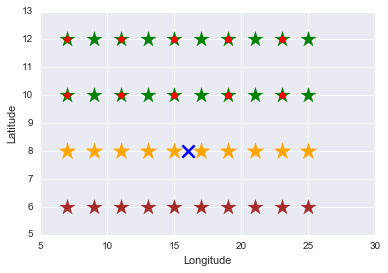

In [268]:
# Plotting the picture

plt.figure()

plt.scatter(reco_user_longitude, reco_user_latitude, color = 'orange', marker = '*', s = 300)
plt.scatter(sim_user_longitude, sim_user_latitude, color = 'green', marker = '*', s = 250)
plt.scatter(reco_longitude_list, reco_latitude_list, color = 'red', marker = 'p', s = 50)
plt.scatter(nsim_user_longitude, nsim_user_latitude, color = 'brown', marker = '*', s = 250)
plt.scatter(median_longitude, median_latitude, color = 'blue',marker='x', s = 150, linewidths=2.5)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

Now lets change first similar user`s 11th rating (rating of the business located in the orange stars row)  from 5 stars to 2 stars and see what recommender engine will recommend in this case:

As you can see from the plot below even though low rated business is the most close located business to the reference user`s median location it has been ignored by the recommender

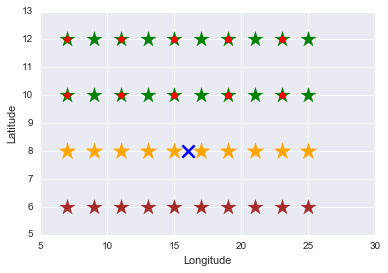

In [292]:
# Plotting the picture

plt.figure()

plt.scatter(reco_user_longitude, reco_user_latitude, color = 'orange', marker = '*', s = 300)
plt.scatter(sim_user_longitude, sim_user_latitude, color = 'green', marker = '*', s = 250)
plt.scatter(reco_longitude_list, reco_latitude_list, color = 'red', marker = 'p', s = 50)
plt.scatter(nsim_user_longitude, nsim_user_latitude, color = 'brown', marker = '*', s = 250)
plt.scatter(median_longitude, median_latitude, color = 'blue',marker='x', s = 150, linewidths=2.5)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

After testing the model lets run it with real data. For this purpose we need to prepare that data first. Lets fetch reviews, users and business datasets and put them together in a single dataframe, so that each row will correspond to an individual review with all data on user who has made a review and a business reviewed by that user: 

In [269]:
reviews_data = list(db.review.find({},{"_id":0, "text":0, "type":0, "friends":0 }))

reviews_df = pd.DataFrame(reviews_data)

reviews_data = []

In [270]:
users_data = list(db.user.find({},{"_id":0, "type":0}))

users_df = pd.DataFrame(users_data)

users_data = []

In [271]:
reviews_users_df = pd.merge(reviews_df, users_df, on='user_id') # merging 2 dataset on user_id

users_df = []

reviews_df = []

In [272]:
# All food related businesses have Restaurants as parent category, thus filtering non-restaurant businesses using parent category 

business_data = list(db.business.find())

substring = 'Restaurants'

restaurants_only = []

for business in business_data:
    
    if substring in business['categories']:
        
        restaurants_only.append(business)
        
    else:
        
        continue
        
rest_only_df = pd.DataFrame(restaurants_only)

business_data = []

In [273]:
big_df = pd.merge(reviews_users_df, rest_only_df, on='business_id') # merging 2 datasets on business_id

reviews_users_df = []

In [274]:
# A recommender system can generate recommendations only when user activity data is available. To make it sure we will only
# consider users with at least 10 reviews

user_group = big_df.groupby('user_id').size()

users_list = []

index = 0

for user_id in user_group.index:
    
    if user_group.values[index] >= 10:
        
        users_list.append(user_id)
        
    index = index + 1

In [275]:
# Making final data preparations (active users filtering and sorting by user_ids)

big_df = big_df[big_df.user_id.isin(users_list) == True]
big_df = big_df.sort_values('user_id')

In [276]:
# Users preference vectors generation takes a long time to compute. We have computed it once and saved it in a separate csv file

users_pref_df = pd.read_csv('users_pref_vectors.csv')
users_pref_df = users_pref_df.set_index('Unnamed: 0')

In [277]:
# Getting tips data

tips_data = list(db.tip.find({},{"business_id":1,"user_id":1, "_id":0}))
tips_df = pd.DataFrame(tips_data)
tips_data = []
business_data = list(db.business.find({},{"latitude":1,"longitude":1, "business_id":1, "city":1, "_id":0}))
business_df = pd.DataFrame(business_data)
business_data = []
tips_loc_df = pd.merge(tips_df, business_df, on='business_id')
tips_df = []
business_df = []

As the model uses median reference user`s location to identify the closest relevant businesses, it may not work well for some users who have reviews for businesses located in different countries or continents. This is why we will generate recommendations for users who have reviews only within one city. Lets call such users "homesitters"

In [278]:
# Randomly choosing 1000 users from the set and identifying if that users are active only in one city in terms of reviews and
# active in one or no cities in terms of tips. If user is passing the check then user id is being recorded into the homesitters list

homesitters = big_df.user_id.unique()

homesitters = np.random.choice(homesitters, size=1000)

homesitters_list = list()

for homesitter in homesitters:
    
    if len(big_df[big_df.user_id == homesitter].groupby('city').size().index.tolist()) == 1:
        
        if len(tips_loc_df[tips_loc_df.user_id == homesitter].groupby('city').size().index.tolist()) <= 1:
            
            homesitters_list.append(homesitter)

In [281]:
homesitters_list[0:10]

['3gQeZj9dlVNlRVI-pcUc4Q',
 'QzM8Ec0h9jCwTSAdp10owA',
 '07rQTc1iCe_C8aZvTxCTdA',
 'gcpgBu2wqgUuJcujapIf0g',
 'gbh8qAkJNnHosIKEMKCEZA',
 '3XDIE54iS2hfq8XcdoAqXQ',
 'T8kaav3upnuqCGYHbWHjqQ',
 'r9pg1UeSLCeIxLDcjghFAw',
 'D-2f-UUrCVhzVSGyGzUvjQ',
 '4uyPe6r3PUqeHZnjwm66wg']

#### Important note:

Due to computational limitations we had to limit a number of considered similar users and corresponding businesses to 200 most similar users and 300 corresponding businesses respectively. Otherwise generating recommendations with the real data (with no limitations) would consume quite a lot of time

In [282]:
# Generating recommendations for a user in the homesitters list

reco_user = 'xyMsaTe21NSByFgQCqfNmw'
user_pref_vector = users_pref_df[users_pref_df.index == reco_user]

In [283]:
user_preferences_dict = ref_user_pref(users_pref_df) 
user_preferences_dict

{'American (New)': 0.043277134527280298,
 'American (Traditional)': 0.043483965014577262,
 'Bakeries': 0.071428571428571425,
 'Barbeque': 0.071428571428571425,
 'Bars': 0.057959183673469375,
 'Breakfast & Brunch': 0.072052644731361928,
 'Cafes': 0.071428571428571425,
 'Coffee & Tea': 0.057142857142857134,
 'Food': 0.072052478134110795,
 'Italian': 0.042857142857142864,
 'Juice Bars & Smoothies': 0.042857142857142864,
 'Mediterranean': 0.057142857142857134,
 'Mexican': 0.057142857142857134,
 'Nightlife': 0.057959183673469375,
 'Pizza': 0.057755102040816325,
 'Restaurants': 0.058172138429205211,
 'Steakhouses': 0.071428571428571425,
 'Tapas Bars': 0.057142857142857134,
 'Tapas/Small Plates': 0.057959183673469375,
 'Vegetarian': 0.057142857142857134,
 'Wine Bars': 0.057142857142857134}

In [284]:
indexes = users_pref_df[users_pref_df.index!= user_pref_vector.index[0]].index # 6
len(indexes)

23624

In [285]:
sorted_user_similarities = cos_similarity(indexes, users_pref_df, user_pref_vector) #7
len(sorted_user_similarities)

23624

In [286]:
similar_users = sorted_user_similarities[-200:] # 8


In [287]:
similar_user_business_rating_list = business_rating(similar_users, big_df) # 9
# List length check
len(similar_user_business_rating_list)

2353

In [288]:
similar_user_business_rating_list = similar_user_business_rating_list[-300:] # 10


In [289]:
reviews_latitude_list = big_df[big_df.user_id == reco_user].latitude.tolist()  # 11
reviews_longitude_list = big_df[big_df.user_id == reco_user].longitude.tolist()
user_mean_latitude = np.median((reviews_latitude_list))
user_mean_longitude = np.median((reviews_longitude_list))

In [290]:
tips_latitude_list = list()

tips_longitude_list = list()

reco_user_tipped_business_ids = tips_loc_df[tips_loc_df.user_id == reco_user].business_id.unique().tolist()

if reco_user_tipped_business_ids != []:
    
    for business in reco_user_tipped_business_ids:
        
        tips_latitude = tips_loc_df[tips_loc_df.business_id == business].latitude.values[0]
        
        tips_longitude = tips_loc_df[tips_loc_df.business_id == business].longitude.values[0]
        
        tips_latitude_list.append(tips_latitude)
        
        tips_longitude_list.append(tips_longitude)
        
else:
    tips_latitude_list = []
    
    tips_longitude_list = []

In [291]:
sim_bus = distance(similar_user_business_rating_list, big_df, user_mean_latitude, user_mean_longitude) # 12

In [292]:
most_close_businesses_list = combination_metric(sim_bus)
len(most_close_businesses_list)

300

In [293]:
pref_weighted_businesses = weight_tastes(most_close_businesses_list, big_df)
len(pref_weighted_businesses)

300

In [294]:
recommended = sorted(pref_weighted_businesses.items(), key = lambda t:t[1])[-10:] 
recommended

[('RFqDK2b5mpasIuAzDoDdDg', 8739.5472505702583),
 ('__kNfrrGoUXoF-BYciMU_Q', 9524.383438600662),
 ('NmEXZjVH9Mq0Vy63hSDMDA', 10105.30942805316),
 ('tGx7BSyqWDeppMvt2aQw_A', 11983.974791639044),
 ('vPDeCSYSD0XOD7r6XwU6wA', 13059.958501517258),
 ('8Nsh8u0zHYegI6XT1L39Lg', 13069.06258724391),
 ('TrbhJJUIX7ed4I8ITSOq3A', 13766.407414859639),
 ('mgN7A6Uw8ObmoTNZvx6VOg', 57100.773232979016),
 ('MhgYfihkb1QZfVpSNLb2uA', 64499.318289523224),
 ('XaNkj7C0-4yERZ9Sysu1fQ', 94182.564334509385)]

In [295]:
reco_longitude_list = list()

reco_latitude_list = list()

for item in recommended:
    
    reco_longitude = rest_only_df[rest_only_df.business_id == item[0]].longitude.values[0]
    
    reco_latitude = rest_only_df[rest_only_df.business_id == item[0]].latitude.values[0]
    
    reco_longitude_list.append(reco_longitude)
    
    reco_latitude_list.append(reco_latitude)

The figure below shows restaurants locations which have been reviewed (green stars) and tipped (orange stars) by the reference user. Red dots correspond to businesses locations that are recommended for the reference user based on user`s preferences and reviews of other users with similar preferences. Blue cross indicates reference user`s median location

We can also see that there is one overlapped recommendation for this particular reference user. (overlapped recommendation is the business which has been recommended by the engine and actually reviewed by the reference user)

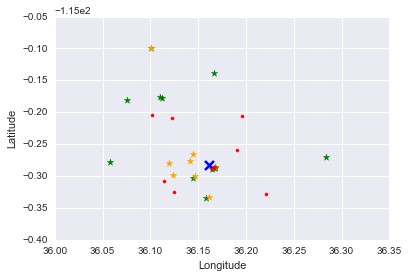

In [298]:
plt.figure()

plt.scatter(reviews_latitude_list, reviews_longitude_list, color = 'green', marker = '*', s = 50) # locations of businesses reviewed by the user
plt.scatter(tips_latitude_list, tips_longitude_list, color = 'orange', marker = '*', s = 50)
plt.scatter(user_mean_latitude, user_mean_longitude, color = 'blue',marker='x', s = 80, linewidths=2.5) # mean location for the user
plt.scatter(reco_latitude_list, reco_longitude_list, color = 'red', s = 10) # recommneded businesses
plt.ylabel('Latitude')
plt.xlabel('Longitude')


Lets evaluate how reference user`s ratings for overlapped recommendations match cumulative ratings of similar users for the same overlapped recommendations. This will give us a little understanding whether a reference users really liked recommended businesses or not. The precision of the model will be identified by computing a mean square error between actual reference user`s ratings and cumulative ratings of similar users for the same overlapped recommendations.

Again, due to single machine`s computational limitations we will run the model only for 100 users collecting reference users ratings and similar users cumulative ratings for all overlapped businesses.

Given that collected ratings data we will compute RMSE...

In [526]:
homesitters = homesitters_list[0:100]

In [527]:
computed_rating_list = []

real_reco_users_rating_list = []

for homesitter in homesitters:
    
    reco_user = homesitter
    
    user_pref_vector = users_pref_df[users_pref_df.index == reco_user]
    
    indexes = users_pref_df[users_pref_df.index!= user_pref_vector.index[0]].index
    
    sorted_user_similarities = cos_similarity(indexes, users_pref_df, user_pref_vector)
    
    similar_users = sorted_user_similarities[-200:]
    
    similar_user_business_rating_list = business_rating(similar_users, big_df)
    
    similar_user_business_rating_list = similar_user_business_rating_list[-300:]
    
    reviews_latitude_list = big_df[big_df.user_id == reco_user].latitude.tolist()
    
    reviews_longitude_list = big_df[big_df.user_id == reco_user].longitude.tolist()
    
    user_mean_latitude = np.median((reviews_latitude_list))
    
    user_mean_longitude = np.median((reviews_longitude_list))
    
    sim_bus = distance(similar_user_business_rating_list, big_df, user_mean_latitude, user_mean_longitude)
    
    most_close_businesses_list = combination_metric(sim_bus)
    
    pref_weighted_businesses = weight_tastes(most_close_businesses_list, big_df)
    
    recommended = sorted(pref_weighted_businesses.items(), key = lambda t:t[1])[-10:]
    
    reviwed_business_ids = big_df[big_df.user_id == reco_user].business_id.values
    
    recommended_business_ids = list()
    
    for reco in recommended:
        
        recommended_business_ids.append(reco[0])
        
    overlapped_reviews = list(set(recommended_business_ids) & set(reviwed_business_ids.tolist()))
    
    for item in similar_user_business_rating_list:
        
        for another_item in overlapped_reviews:
            
            if item[0] == another_item:
                
                computed_rating = item[1]
                
                real_reco_users_rating = big_df[(big_df.user_id == reco_user) & (big_df.business_id == another_item)].stars_x.values
                
                if len(real_reco_users_rating) != 1:
                    
                    real_reco_users_rating = float(real_reco_users_rating.min())
                    
                else:
                    
                    real_reco_users_rating = float(real_reco_users_rating[0])
                    
                computed_rating_list.append(computed_rating)
                
                real_reco_users_rating_list.append(real_reco_users_rating)
                    
            else:  
                
                continue
                
print(computed_rating_list, real_reco_users_rating_list)                    

[5.0, 5.0, 5.0, 5.0, 4.466534455911477, 4.494564960951103, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0000000000000009, 4.075991528679021, 4.084959422929139, 5.0, 5.0, 4.201742813835115, 4.254238601524005, 5.0, 5.0, 5.0, 5.000000000000001, 5.000000000000001, 4.560502138023534, 4.711807830355102, 5.0, 5.0, 5.0, 5.0] [4.0, 2.0, 3.0, 5.0, 5.0, 5.0, 1.0, 4.0, 3.0, 3.0, 3.0, 5.0, 4.0, 5.0, 4.0, 3.0, 5.0, 4.0, 4.0, 5.0, 1.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0, 4.0, 4.0, 4.0, 5.0]


In [531]:
RMSE = np.sqrt(np.mean(np.power(np.array(computed_rating_list) - np.array(real_reco_users_rating_list), 2)))

RMSE

1.4812772465079722